In [1]:
%matplotlib inline

import chb
import scipy.io as sio
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection


In [2]:
chb1 = chb.load_meta('chb01')
chb1 = chb.load_data(chb1,EXTHD=False)

Loading: /Users/adamcellon/Drive/senior/thesis/data/chb01.npz
Done: 71.007349 seconds elapsed.


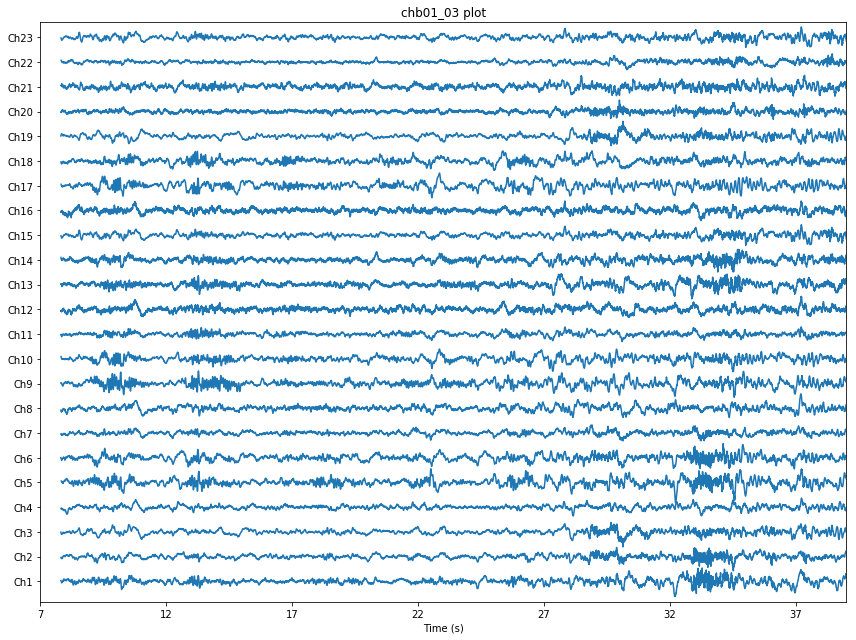

In [3]:
chb1[2].plot(2000,10000)

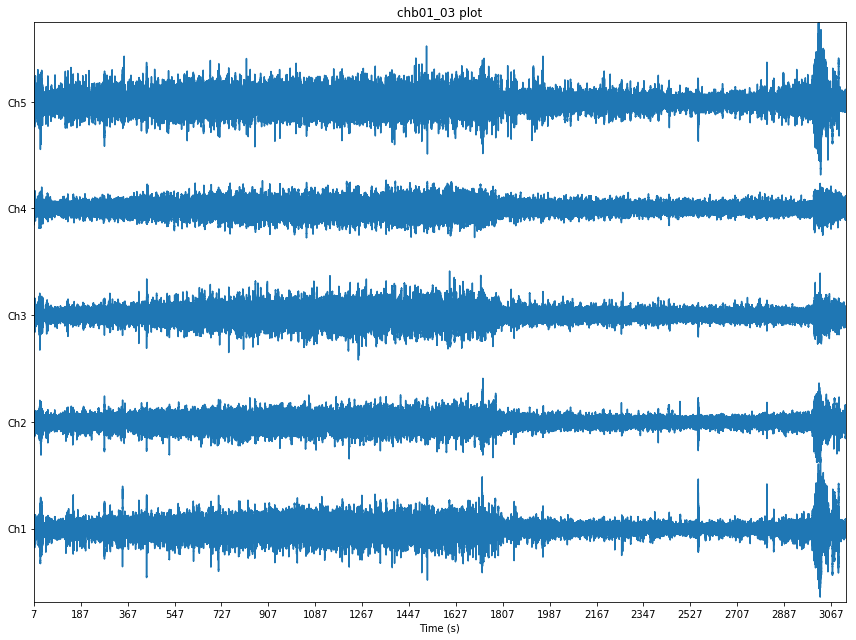

In [4]:
chb1[2].plot(2000, 800000, 1, 5)

## Making epochs

In [5]:
start = time.clock()
label, epoch = chb.label_epochs(chb1)
stop = time.clock()
print('%f seconds' % (stop-start))

3.698373 seconds
